# setup

In [18]:
import datetime
import gc
import hashlib
import json
import os
import pickle
import pprint
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from IPython.display import display
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    f1_score,
    fbeta_score,
    mean_squared_error,
    r2_score,
    roc_curve,
)
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize

from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_style("whitegrid")

golden_ratio = (np.sqrt(5) - 1) / 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [3]:
plt.rcParams.update({
    'font.size'       : 9,
    'figure.figsize'  : (3.5, 2.8),
    'figure.dpi'      : 300,
    'savefig.dpi'     : 300,
    'text.usetex'     : True,
    'font.family'     : 'serif',
    'font.serif'      : ['Times New Roman'],
    'axes.labelsize'  : 9,
    'axes.titlesize'  : 9,
    'xtick.labelsize' : 8,
    'ytick.labelsize' : 8,
    'legend.fontsize' : 8,
    'lines.linewidth' : 1,
    'axes.linewidth'  : 1,
    'grid.linestyle'  : '--',
    'grid.linewidth'  : 0.5,
    'grid.alpha'      : 0.8,
})

sns.set_context(
    "paper", 
    rc={
        "font.size"      : 9,
        "axes.titlesize" : 9,
        "axes.labelsize" : 9, 
        'xtick.labelsize': 8,
        'ytick.labelsize': 8
    }
)

In [6]:
experiment_name = "ryckaert-bellemans"
folder_path = f"../data/08_reporting/{experiment_name}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# functions

In [4]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

# interpolation

$$V_{rb}(\phi_{ijkl}) = \sum_{n=0}^5 C_n \left( \cos(\psi) \right)^n = V_{rb}(\phi_{ijkl}) = \sum_{n=0}^5 C_n \left( \cos(\phi - 180^\circ) \right)^n$$

[which can be rewritten as Fourier Dihedral](https://manual.gromacs.org/current/reference-manual/functions/bonded-interactions.html#proper-dihedrals-ryckaert-bellemans-function)

$$ V_{rb}(\phi_{ijkl}) = \frac{1}{2} \left[ F_1(1 + \cos(\phi)) + F_2(1 - \cos(2\phi)) + F_3(1 + \cos(3\phi)) + F_4(1 - \cos(4\phi)) \right] $$

where

* $C_0 = F_2 + \frac{1}{2}\left( F_1 + F_3 \right)$
* $C_1 = \frac{1}{2}\left( -F_1 + 3F_3 \right)$
* $C_2 = -F_2 + 4F_4$
* $C_3 = -2F_3$
* $C_4 = -4F_4$
* $C_5 = 0$

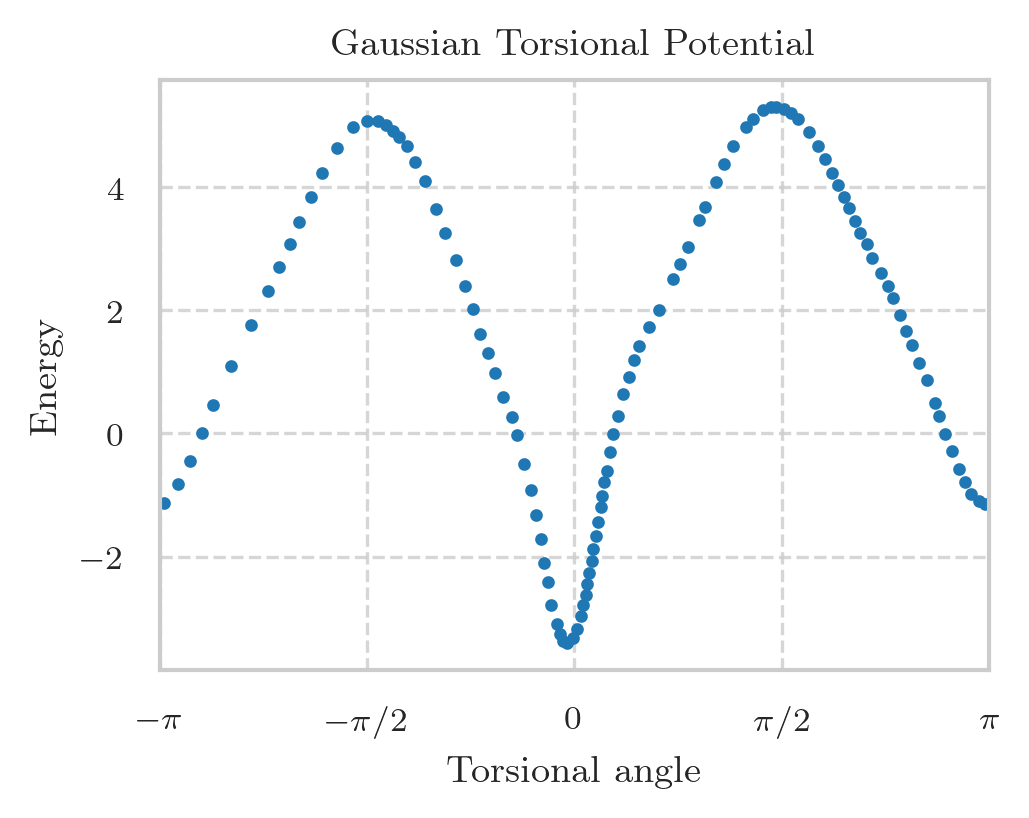

In [72]:
df = pd.read_csv("~/Downloads/Gaussian_torsional (1).csv", delimiter=";", header=None, decimal=',')
df[[0, 1]] = df[[0, 1]].astype(np.float64)
df[0] = np.radians(df[0])

df.plot(x=0, y=1, kind='scatter', marker='.')

plt.xlabel('Torsional angle')
plt.xlim(-np.pi, np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])

plt.ylabel('Energy')

plt.title('Gaussian Torsional Potential')
plt.tight_layout()
plt.savefig(f"{folder_path}/plot_scatter_gaussian_torsional.png")

# fitting

In [14]:
parameters = pd.read_csv("~/Downloads/Gaussian_torsional (1).csv", delimiter=";", header=None, decimal=',')
parameters = parameters.sort_values(by=0)
display(parameters.head())

angles = pd.read_csv("~/Downloads/parametrizacao_ff (1).csv", delimiter=",", decimal=',')
display(angles.head())

,0,1,2,3
0,-178.047967,-1.130435,,
1,-172.166218,-0.821256,50,50
2,-166.807747,-0.454106,50,50
3,-161.436450,0.009662,50,50
4,-156.598692,0.454106,50,50


,14-13-9-4,14-13-9-11,17-13-9-4,17-13-9-11
0,-145.86,34.57,37.17,-145.86
1,-135.86,44.57,47.17,-135.86
2,-125.86,54.57,57.17,-125.86
3,-115.86,64.57,67.17,-115.86
4,-105.86,74.57,77.17,-105.86


## as is

### interpolation, transformation, and fitting

In [16]:
interpolarizador = CubicSpline(parameters[0], parameters[1])
angles["ans"] = angles.apply(lambda x: interpolarizador(x["14-13-9-4"]), axis=1)

In [17]:
df = angles[["ans"]].copy().rename(columns={"ans":"y"})

phi_1 = 0
phi_2 = 0
phi_3 = 0
phi_4 = 0

for c in angles.drop(columns=["ans"]).columns:
    df[f"{c}_V1"] = 0.5 * (1 + np.cos(1 * np.radians(angles[c]) - phi_1))
    df[f"{c}_V2"] = 0.5 * (1 - np.cos(2 * np.radians(angles[c]) - phi_2))
    df[f"{c}_V3"] = 0.5 * (1 + np.cos(3 * np.radians(angles[c]) - phi_3))
    df[f"{c}_V4"] = 0.5 * (1 - np.cos(4 * np.radians(angles[c]) - phi_4)) 

In [21]:
X = df.drop(columns=["y"])
y = df["y"]

reg = LinearRegression(fit_intercept=False)
reg.fit(X,y)

LinearRegression(fit_intercept=False)

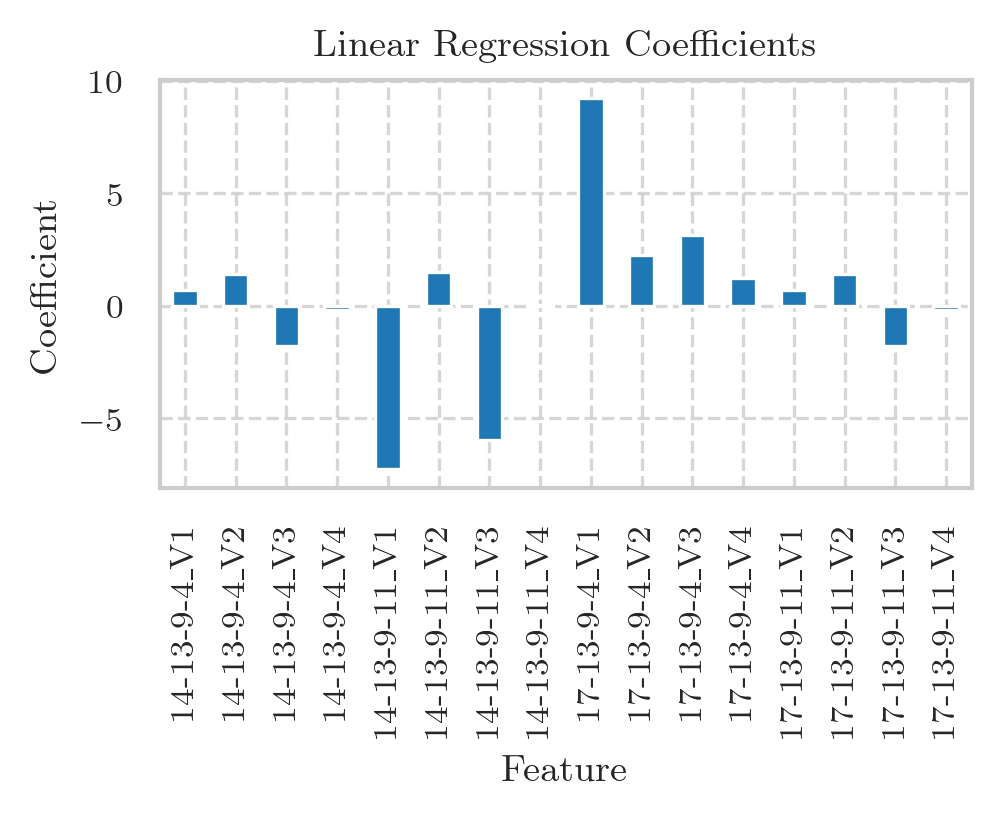

In [27]:
fig, ax = plt.subplots(1, 1)

pd.Series(reg.coef_.flatten(), X.columns.values.flatten()).plot(kind='bar', ax=ax)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Feature')
ax.set_title('Linear Regression Coefficients')

plt.tight_layout()
plt.savefig(f"{folder_path}/plot_linear_regression_coefficients.png")

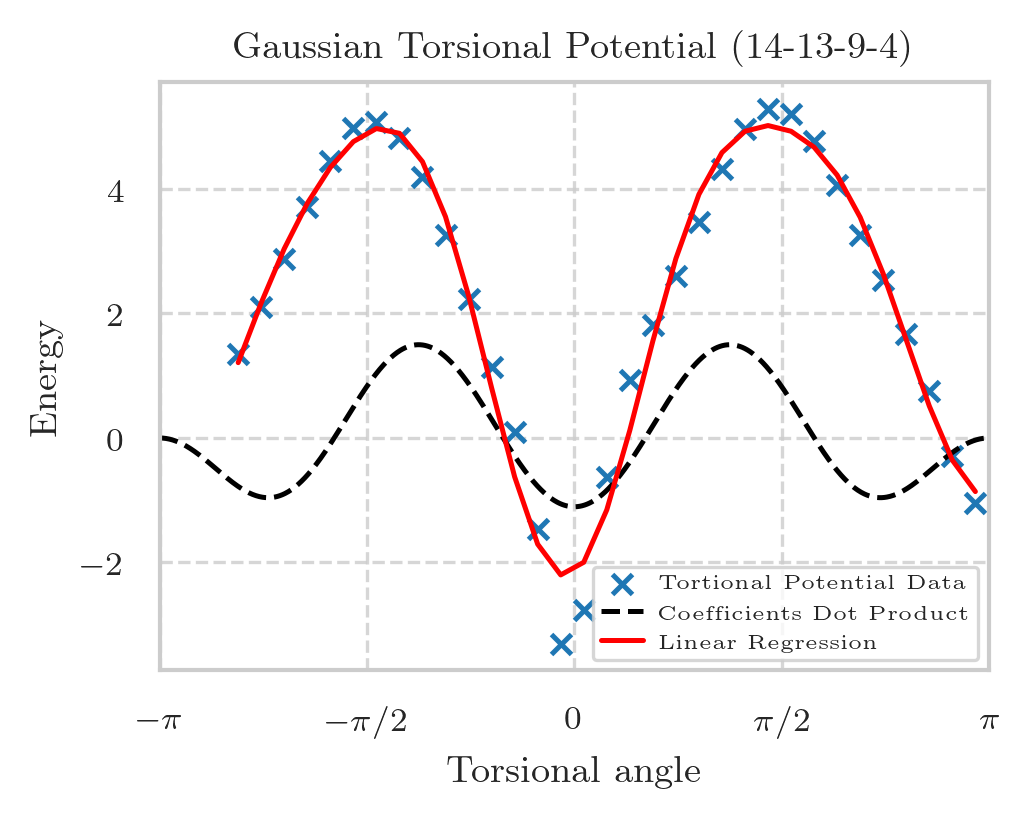

In [84]:
fig, ax = plt.subplots(1, 1)

_plot = pd.DataFrame()
for i in np.linspace(-np.pi, np.pi, 1000):
    _plot = pd.concat([
        _plot,
        pd.DataFrame(
        [
            [
                i,
                0.5 * (1 + np.cos(1 * i - phi_1)), 
                0.5 * (1 - np.cos(2 * i - phi_2)), 
                0.5 * (1 + np.cos(3 * i - phi_3)), 
                0.5 * (1 - np.cos(4 * i - phi_4))
            ]
        ], columns=["14-13-9-4", "14-13-9-4_V1", "14-13-9-4_V2", "14-13-9-4_V3", "14-13-9-4_V4"]
        ),
    ])
_plot["y_pred"] = np.dot(reg.coef_[:4], _plot[["14-13-9-4_V1", "14-13-9-4_V2", "14-13-9-4_V3", "14-13-9-4_V4"]].T)

ax.scatter(
    angles["14-13-9-4"].apply(lambda x: np.radians(x)), 
    angles["ans"], 
    marker='x', 
    label="Tortional Potential Data",
)
ax.plot(
    _plot["14-13-9-4"], 
    _plot["y_pred"], 
    label="Coefficients Dot Product",
    linestyle='--',
    color='k'
)
ax.plot(
    angles["14-13-9-4"].apply(lambda x: np.radians(x)), 
    np.dot(X.values, reg.coef_),
    label="Linear Regression",
    color='r'
)

ax.legend(fontsize=5, loc="best")

plt.xlabel('Torsional angle')
plt.xlim(-np.pi, np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])

plt.ylabel('Energy')

plt.title('Gaussian Torsional Potential (14-13-9-4)')
plt.tight_layout()

plt.savefig(f"{folder_path}/plot_linear_regression.png")

## alternative approach

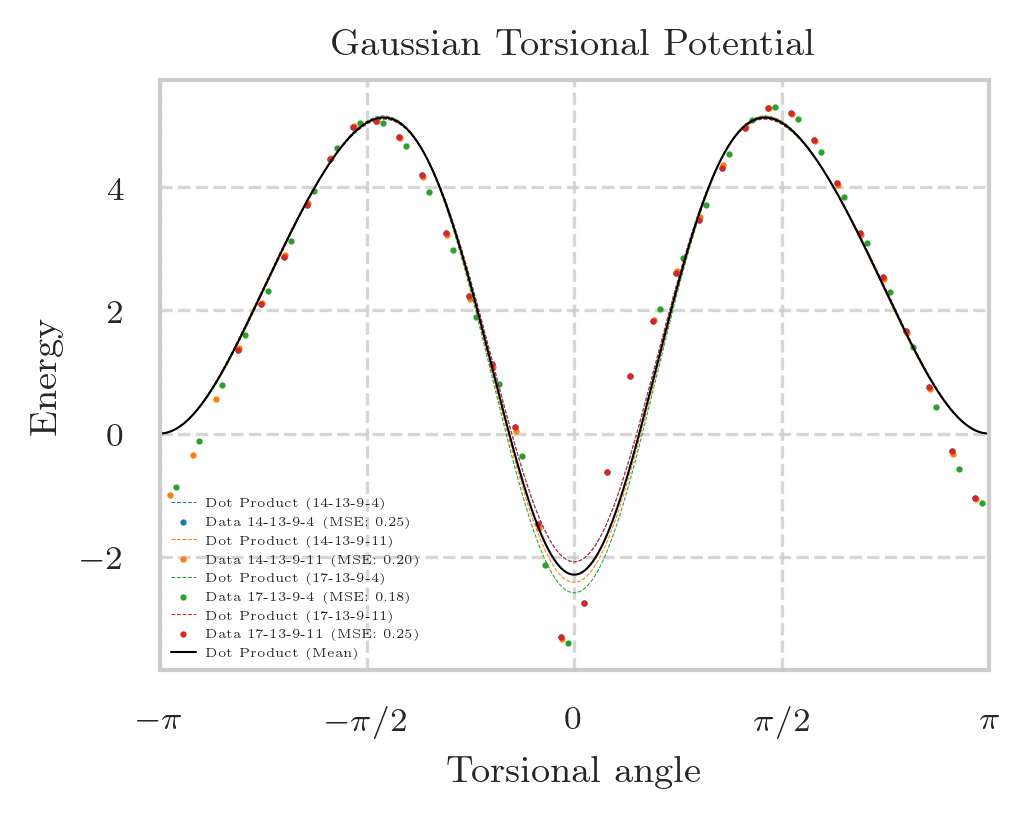

In [170]:
fig, ax = plt.subplots(1, 1)

regressors = dict()

phi_1 = 0
phi_2 = 0
phi_3 = 0
phi_4 = 0

for c in angles.drop(columns=["ans"]).columns:
    angles["ans"] = angles.apply(lambda x: interpolarizador(x[c]), axis=1)

    df = angles[["ans"]].copy().rename(columns={"ans":"y"})
    df[f"{c}_V1"] = 0.5 * (1 + np.cos(1 * np.radians(angles[c]) - phi_1))
    df[f"{c}_V2"] = 0.5 * (1 - np.cos(2 * np.radians(angles[c]) - phi_2))
    df[f"{c}_V3"] = 0.5 * (1 + np.cos(3 * np.radians(angles[c]) - phi_3))
    df[f"{c}_V4"] = 0.5 * (1 - np.cos(4 * np.radians(angles[c]) - phi_4)) 

    X = df.drop(columns=["y"])
    y = df["y"]

    reg = LinearRegression(fit_intercept=False)
    reg.fit(X,y)
    regressors[c] = reg

    _plot = pd.DataFrame()
    for i in np.linspace(-np.pi, np.pi, 1000):
        _plot = pd.concat([
            _plot,
            pd.DataFrame(
            [
                [
                    i,
                    0.5 * (1 + np.cos(1 * i - phi_1)), 
                    0.5 * (1 - np.cos(2 * i - phi_2)), 
                    0.5 * (1 + np.cos(3 * i - phi_3)), 
                    0.5 * (1 - np.cos(4 * i - phi_4))
                ]
            ], columns=[c, f"{c}_V1", f"{c}_V2", f"{c}_V3", f"{c}_V4"]
            ),
        ])
    _plot["y_pred"] = np.dot(reg.coef_[:4], _plot[[f"{c}_V1", f"{c}_V2", f"{c}_V3", f"{c}_V4"]].T)
    ax.plot(
        _plot[c], 
        _plot["y_pred"], 
        label=f"Dot Product ({c})",
        linestyle='--',
        linewidth=0.25
    )
    _mse = mean_squared_error(
        y,
        np.dot(X.values, reg.coef_)
    )
    ax.scatter(
        angles[c].apply(lambda x: np.radians(x)), 
        angles["ans"], 
        marker='.',
        label=f"Data {c} (MSE: {_mse:.2f})",
        s=2
    )


_results = pd.DataFrame([[k]+ list(v.coef_) for k, v in regressors.items()], columns=["angle", "V1", "V2", "V3", "V4"])
_plot = pd.DataFrame()
for i in np.linspace(-np.pi, np.pi, 1000):
    _plot = pd.concat([
        _plot,
        pd.DataFrame(
        [
            [   i,
                0.5 * (1 + np.cos(1 * i - phi_1)), 
                0.5 * (1 - np.cos(2 * i - phi_2)), 
                0.5 * (1 + np.cos(3 * i - phi_3)), 
                0.5 * (1 - np.cos(4 * i - phi_4))
            ]
        ], columns=["angle", "V1", "V2", "V3", "V4"]
        ),
    ])
_plot["y_pred"] = np.dot(
    _results[["V1", "V2", "V3", "V4"]].mean(axis=0),
    _plot[["V1", "V2", "V3", "V4"]].T
)
ax.plot(
    _plot["angle"],
    _plot["y_pred"],
    label="Dot Product (Mean)",
    color='k', 
    linewidth=0.5
)

ax.legend(fontsize=3, loc="best", markerscale=1, scatterpoints=1, frameon=False, edgecolor=None)

plt.xlabel('Torsional angle')
plt.xlim(-np.pi, np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])

plt.ylabel('Energy')

plt.title('Gaussian Torsional Potential')

plt.tight_layout()

,angle,V1,V2,V3,V4
0,14-13-9-4,-0.947928,6.06840,-1.134512,0.433804
1,14-13-9-11,-1.166276,6.27859,-1.250503,0.404839
2,17-13-9-4,-1.288893,6.36612,-1.297100,0.426051
3,17-13-9-11,-0.947928,6.06840,-1.134512,0.433804


V1: -1.0877562181469527 +- 0.14639441863351985
V2: 6.195377394142531 +- 0.13069425157324882
V3: -1.2041563428692974 +- 0.07156681626505412
V4: 0.4246245764683755 +- 0.011853261383806038


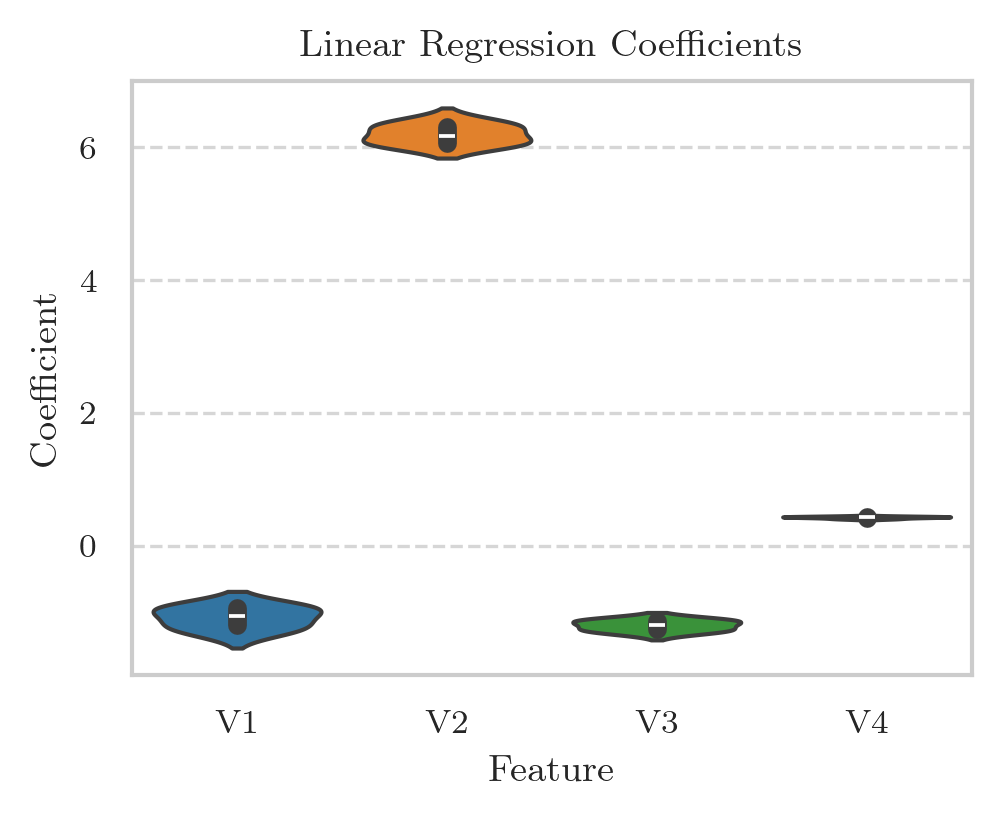

In [171]:
_results = pd.DataFrame([[k]+ list(v.coef_) for k, v in regressors.items()], columns=["angle", "V1", "V2", "V3", "V4"])
_results.to_csv(f"{folder_path}/coefficients.csv", index=False)

display(_results.head())

print(f"V1: {np.mean(_results['V1'])} +- {np.std(_results['V1'])}")
print(f"V2: {np.mean(_results['V2'])} +- {np.std(_results['V2'])}")
print(f"V3: {np.mean(_results['V3'])} +- {np.std(_results['V3'])}")
print(f"V4: {np.mean(_results['V4'])} +- {np.std(_results['V4'])}")

sns.violinplot(data=_results.drop(columns=["angle"]), orient="v")
plt.ylabel('Coefficient')
plt.xlabel('Feature')
plt.title('Linear Regression Coefficients')

plt.tight_layout()
plt.savefig(f"{folder_path}/plot_linear_regression_coefficients_violin.png")


In [172]:
pd.DataFrame([[k]+ list(v.coef_) for k, v in regressors.items()], columns=["angle", "V1", "V2", "V3", "V4"])

,angle,V1,V2,V3,V4
0,14-13-9-4,-0.947928,6.06840,-1.134512,0.433804
1,14-13-9-11,-1.166276,6.27859,-1.250503,0.404839
2,17-13-9-4,-1.288893,6.36612,-1.297100,0.426051
3,17-13-9-11,-0.947928,6.06840,-1.134512,0.433804


# pinn for parameter learning

14-13-9-4


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 35/30000 [00:00<01:28, 339.98it/s]

epoch: 0, dataloss: 11.3651, physicsloss: 10.9025


 17%|█▋        | 5128/30000 [00:08<00:39, 630.10it/s]

epoch: 5000, dataloss: 0.0155, physicsloss: 0.5656


 34%|███▎      | 10083/30000 [00:17<00:35, 565.69it/s]

epoch: 10000, dataloss: 0.0019, physicsloss: 0.1886


 50%|█████     | 15090/30000 [00:25<00:26, 556.07it/s]

epoch: 15000, dataloss: 0.0134, physicsloss: 0.1835


 67%|██████▋   | 20076/30000 [00:34<00:15, 645.81it/s]

epoch: 20000, dataloss: 0.0003, physicsloss: 0.1835


 84%|████████▎ | 25079/30000 [00:42<00:07, 671.22it/s]

epoch: 25000, dataloss: 0.0012, physicsloss: 0.1835


100%|██████████| 30000/30000 [00:51<00:00, 587.58it/s]


C_0: 4.957618236541748
C_1: -0.047918375581502914
C_2: -3.4401907920837402
C_3: -1.8364957571029663
C_4: -3.024580478668213
C_5: 2.703946113586426
14-13-9-11


  0%|          | 0/30000 [00:00<?, ?it/s]

epoch: 0, dataloss: 31.4750, physicsloss: 10.6914


 17%|█▋        | 5070/30000 [00:08<00:47, 529.37it/s]

epoch: 5000, dataloss: 0.0400, physicsloss: 0.4791


 34%|███▎      | 10087/30000 [00:17<00:37, 524.45it/s]

epoch: 10000, dataloss: 0.0016, physicsloss: 0.0957


 50%|█████     | 15063/30000 [00:26<00:25, 582.76it/s]

epoch: 15000, dataloss: 0.0030, physicsloss: 0.0921


 67%|██████▋   | 20091/30000 [00:35<00:19, 510.08it/s]

epoch: 20000, dataloss: 0.0061, physicsloss: 0.0921


 84%|████████▎ | 25102/30000 [00:44<00:08, 601.06it/s]

epoch: 25000, dataloss: 0.0003, physicsloss: 0.0921


100%|██████████| 30000/30000 [00:53<00:00, 563.33it/s]


C_0: 4.959897041320801
C_1: -0.3584676682949066
C_2: -3.332097053527832
C_3: -0.5127438306808472
C_4: -3.3924942016601562
C_5: 1.8351380825042725
17-13-9-4


  0%|          | 52/30000 [00:00<00:57, 519.77it/s]

epoch: 0, dataloss: 18.1384, physicsloss: 10.7557


 17%|█▋        | 5106/30000 [00:08<00:45, 549.86it/s]

epoch: 5000, dataloss: 0.0107, physicsloss: 0.4611


 34%|███▎      | 10075/30000 [00:17<00:30, 657.62it/s]

epoch: 10000, dataloss: 0.0030, physicsloss: 0.0795


 50%|█████     | 15090/30000 [00:25<00:26, 559.93it/s]

epoch: 15000, dataloss: 0.0181, physicsloss: 0.0768


 67%|██████▋   | 20099/30000 [00:34<00:17, 579.67it/s]

epoch: 20000, dataloss: 0.0098, physicsloss: 0.0768


 84%|████████▎ | 25100/30000 [00:43<00:09, 517.73it/s]

epoch: 25000, dataloss: 0.0013, physicsloss: 0.0768


100%|██████████| 30000/30000 [00:51<00:00, 579.96it/s]


C_0: 4.964388370513916
C_1: -0.40090247988700867
C_2: -3.3586318492889404
C_3: -0.26018789410591125
C_4: -3.434359550476074
C_5: 1.6776738166809082
17-13-9-11


  0%|          | 49/30000 [00:00<01:01, 486.63it/s]

epoch: 0, dataloss: 11.4559, physicsloss: 10.9025


 17%|█▋        | 5070/30000 [00:08<00:45, 543.38it/s]

epoch: 5000, dataloss: 0.0055, physicsloss: 0.5656


 34%|███▎      | 10104/30000 [00:17<00:33, 594.97it/s]

epoch: 10000, dataloss: 0.0043, physicsloss: 0.1886


 50%|█████     | 15074/30000 [00:26<00:24, 602.16it/s]

epoch: 15000, dataloss: 0.0018, physicsloss: 0.1835


 67%|██████▋   | 20092/30000 [00:35<00:16, 586.87it/s]

epoch: 20000, dataloss: 0.0010, physicsloss: 0.1835


 84%|████████▎ | 25079/30000 [00:44<00:08, 584.27it/s]

epoch: 25000, dataloss: 0.0006, physicsloss: 0.1835


100%|██████████| 30000/30000 [00:52<00:00, 575.45it/s]


C_0: 4.957618236541748
C_1: -0.047918375581502914
C_2: -3.4401907920837402
C_3: -1.8364957571029663
C_4: -3.024580478668213
C_5: 2.703946113586426


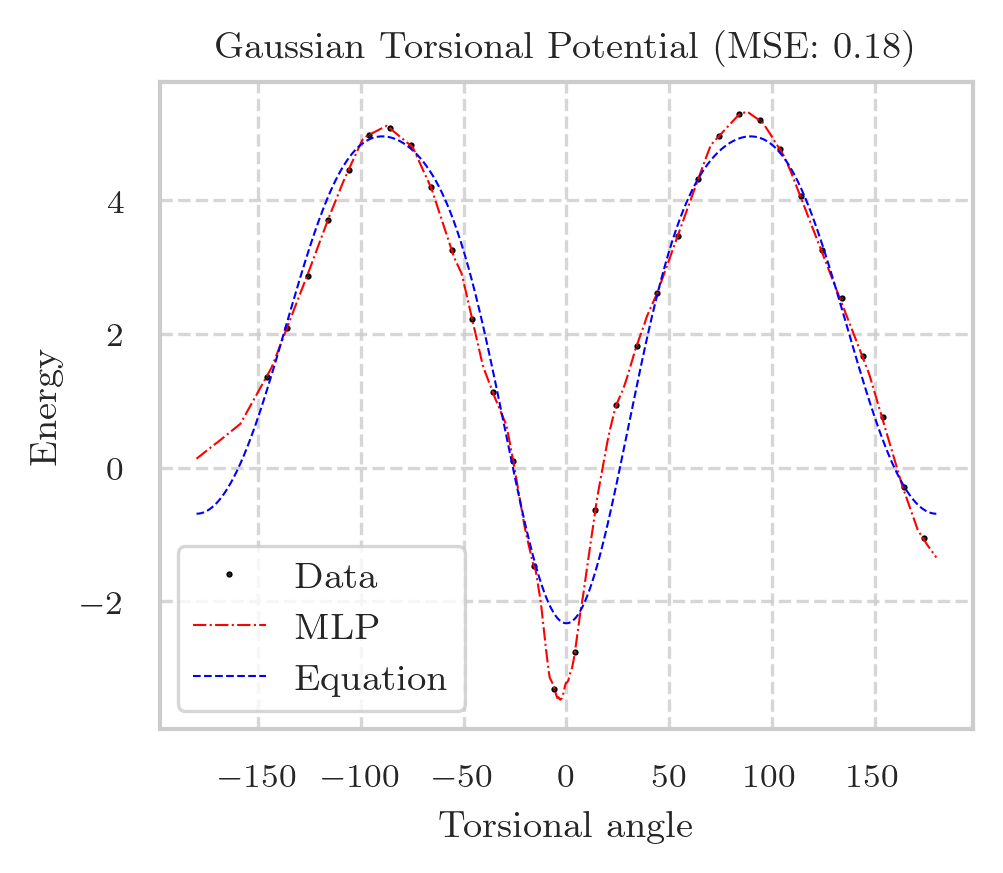

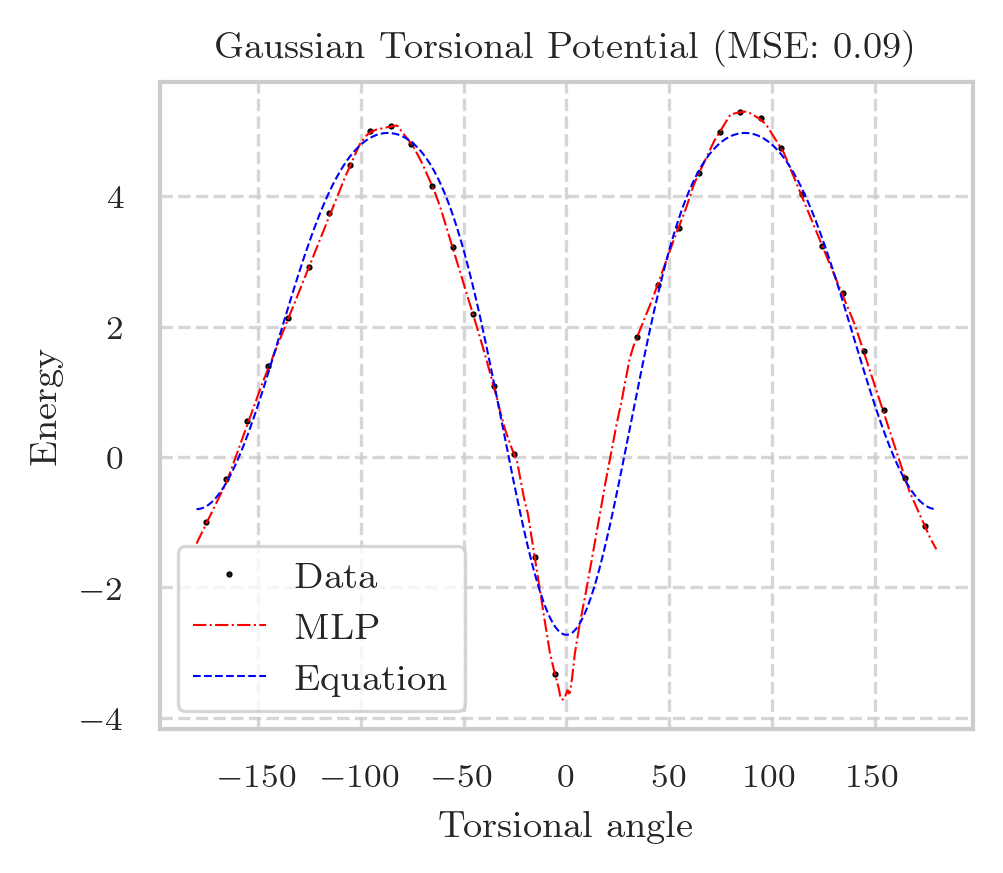

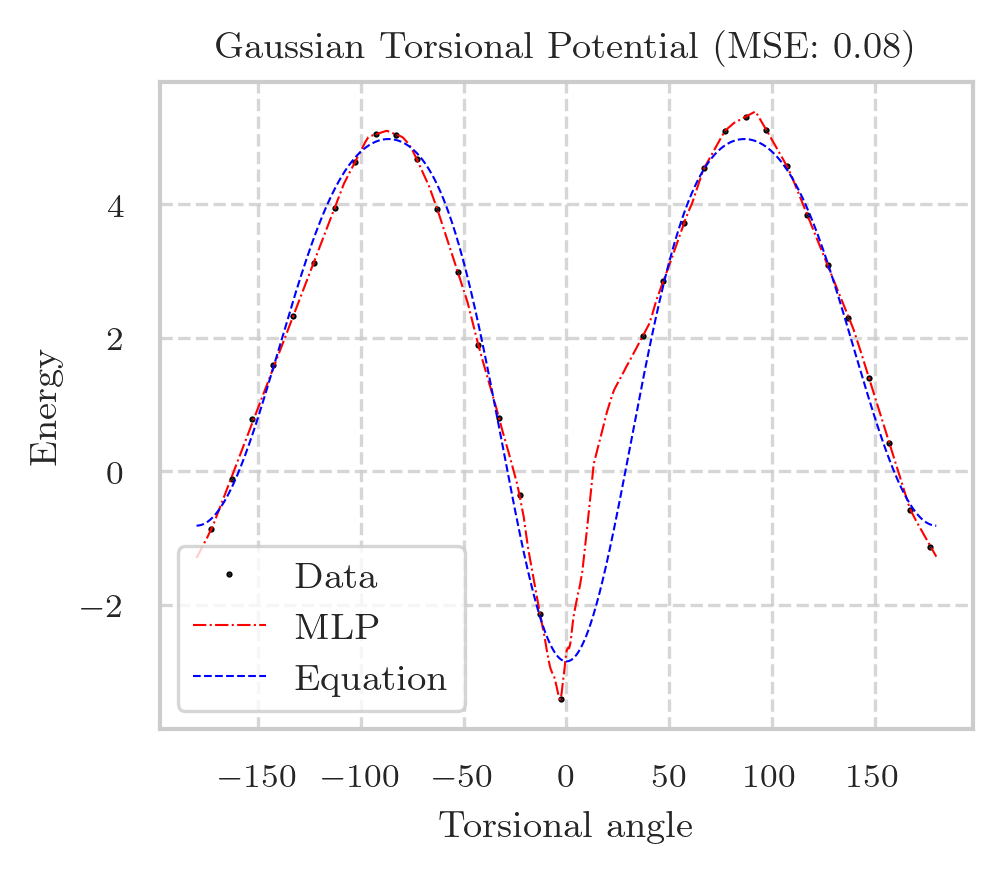

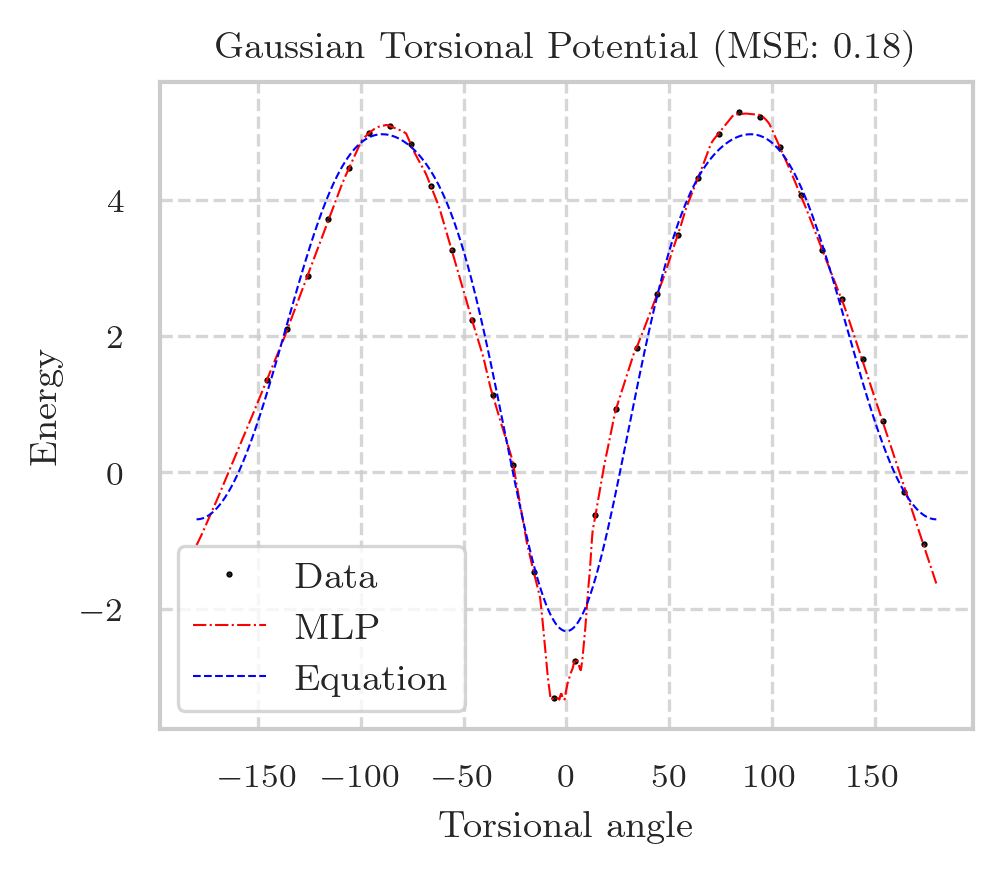

In [203]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

hparam_dict = {
    'activation': nn.LeakyReLU,
    'lambda_physics_loss': 0.0001,
    'learning_rate': 0.001,
    'n_layers': 4,
    'n_neurons': 32,
    'num_collocation_points': 20,
    'num_epochs': 30000
}
_architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]

plot_loss_train = dict(
    epoch=list(),
    dataloss=list(), 
    physicsloss=list(), 
)

for c in angles.drop(columns=["ans"]).columns:
    print(c)
    angles["ans"] = angles.apply(lambda x: interpolarizador(x[c]), axis=1)
    x_train = torch.tensor(angles[c].astype(np.float64).values.reshape(-1, 1), dtype=torch.float32, device=device)
    y_train = torch.tensor(angles["ans"].astype(np.float64).values.reshape(-1, 1), dtype=torch.float32, device=device)

    _C0 = torch.tensor(0.0, dtype=torch.float32, requires_grad=True, device=device)
    _C1 = torch.tensor(0.0, dtype=torch.float32, requires_grad=True, device=device)
    _C2 = torch.tensor(0.0, dtype=torch.float32, requires_grad=True, device=device)
    _C3 = torch.tensor(0.0, dtype=torch.float32, requires_grad=True, device=device)
    _C4 = torch.tensor(0.0, dtype=torch.float32, requires_grad=True, device=device)
    _C5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=True, device=device)

    model = MultiLayerPerceptronRegressor(_architecture, hparam_dict["activation"]).to(device)
    optimizer = optim.Adam(
        [
            {"params": model.parameters()}, 
            {"params": [_C0, _C1, _C2, _C3, _C4, _C5]}
        ], 
        lr=hparam_dict["learning_rate"]
    )
    criterion = nn.MSELoss()

    for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
        optimizer.zero_grad()

        # forward
        y_train_hat = model(x_train)
        
        data_loss = criterion(y_train_hat, y_train)

        radians = x_train[:,0] * np.pi / 180.0

        _c0 = _C0*(torch.cos(radians - np.pi))**0
        _c1 = _C1*(torch.cos(radians - np.pi))**1
        _c2 = _C2*(torch.cos(radians - np.pi))**2
        _c3 = _C3*(torch.cos(radians - np.pi))**3
        _c4 = _C4*(torch.cos(radians - np.pi))**4
        _c5 = _C5*(torch.cos(radians - np.pi))**5

        equation_loss = criterion(
            y_train[:,0],
            _c0 + _c1 + _c2 + _c3 + _c4 + _c5
        )

        loss = data_loss + equation_loss
        
        # backward
        loss.backward()
        optimizer.step()

        if epoch % 5000 == 0:
            plot_loss_train["epoch"].append(epoch)
            plot_loss_train["dataloss"].append(data_loss.item())
            plot_loss_train["physicsloss"].append(equation_loss.item())

            print(
                f"epoch: {epoch}, dataloss: {data_loss.item():.4f}, physicsloss: {equation_loss.item():.4f}"
            )

    gc.collect()

    print(f"C_0: {_C0.item()}")
    print(f"C_1: {_C1.item()}")
    print(f"C_2: {_C2.item()}")
    print(f"C_3: {_C3.item()}")
    print(f"C_4: {_C4.item()}")
    print(f"C_5: {_C5.item()}")

    fig, ax = plt.subplots(1, 1)

    model.eval()

    with torch.no_grad():
        ax.plot(
            x_train.cpu().numpy(), 
            y_train.cpu().numpy(),
            label="Data",
            marker='.',
            linestyle='None',
            color='k',
            markersize=1
        )
        _x = np.linspace(-180, 180, 1000)
        _y = model(torch.tensor(_x.reshape(-1, 1), dtype=torch.float32, device=device)).cpu().numpy()
        _equation = _C0.item()*(np.cos(np.radians(_x - 180)))**0 + _C1.item()*(np.cos(np.radians(_x - 180)))**1 + _C2.item()*(np.cos(np.radians(_x - 180)))**2 + _C3.item()*(np.cos(np.radians(_x - 180)))**3 + _C4.item()*(np.cos(np.radians(_x - 180)))**4 + _C5.item()*(np.cos(np.radians(_x - 180)))**5
        ax.plot(
            _x, 
            _y,
            label="MLP",
            linestyle="-.",
            color='r',
            linewidth=0.5
        )
        ax.plot(
            _x, 
            _equation,
            label="Equation",
            linestyle="--",
            color='b',
            linewidth=0.5
        )
        
        _equation_mse = mean_squared_error(
            y_train.cpu().numpy(),
            _C0.item()*(np.cos(np.radians(x_train.cpu().numpy() - 180)))**0 + _C1.item()*(np.cos(np.radians(x_train.cpu().numpy() - 180)))**1 + _C2.item()*(np.cos(np.radians(x_train.cpu().numpy() - 180)))**2 + _C3.item()*(np.cos(np.radians(x_train.cpu().numpy() - 180)))**3 + _C4.item()*(np.cos(np.radians(x_train.cpu().numpy() - 180)))**4 + _C5.item()*(np.cos(np.radians(x_train.cpu().numpy() - 180)))**5
        )
        

    ax.legend()

    plt.xlabel('Torsional angle')
    plt.ylabel('Energy')
    plt.title(f'Gaussian Torsional Potential (MSE: {_equation_mse:.2f})')
    plt.savefig(f"{folder_path}/plot_mlp_regression_{c}.png")


## double check

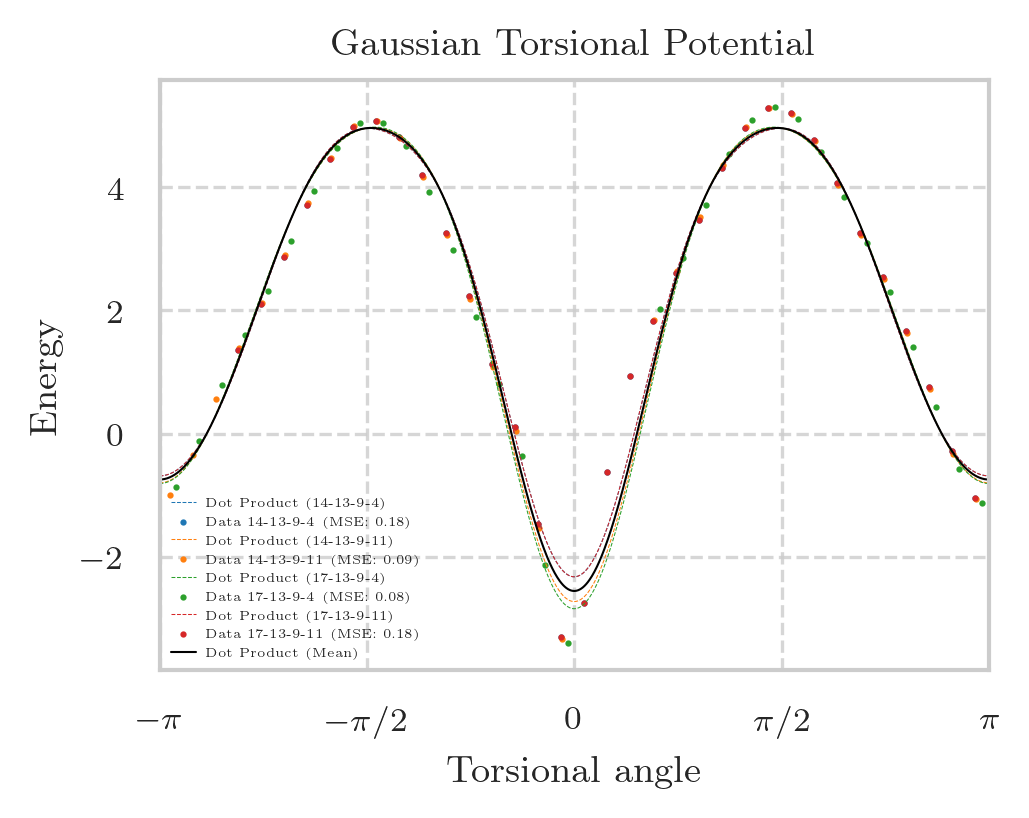

In [221]:
parameters = pd.read_csv("~/Downloads/Gaussian_torsional (1).csv", delimiter=";", header=None, decimal=',')
parameters = parameters.sort_values(by=0)

angles = pd.read_csv("~/Downloads/parametrizacao_ff (1).csv", delimiter=",", decimal=',')

fig, ax = plt.subplots(1, 1)

regressors = dict()

phi_1 = 0
phi_2 = 0
phi_3 = 0
phi_4 = 0

for c in angles.drop(columns=["y"], errors="ignore").columns:
    angles["ans"] = angles.apply(lambda x: interpolarizador(x[c]), axis=1)

    df = angles[["ans"]].copy().rename(columns={"ans":"y"})
    df[f"{c}_V0"] = np.cos(np.radians(angles[c] - 180))**0
    df[f"{c}_V1"] = np.cos(np.radians(angles[c] - 180))**1
    df[f"{c}_V2"] = np.cos(np.radians(angles[c] - 180))**2
    df[f"{c}_V3"] = np.cos(np.radians(angles[c] - 180))**3
    df[f"{c}_V4"] = np.cos(np.radians(angles[c] - 180))**4
    df[f"{c}_V5"] = np.cos(np.radians(angles[c] - 180))**5


    X = df.drop(columns=["y"])
    y = df["y"]

    reg = LinearRegression(fit_intercept=False)
    reg.fit(X,y)
    regressors[c] = reg

    _plot = pd.DataFrame()
    for i in np.linspace(-180, 180, 1000):
        _plot = pd.concat([
            _plot,
            pd.DataFrame(
            [
                [
                    np.radians(i),
                    np.cos(np.radians(i - 180))**0,
                    np.cos(np.radians(i - 180))**1,
                    np.cos(np.radians(i - 180))**2,
                    np.cos(np.radians(i - 180))**3,
                    np.cos(np.radians(i - 180))**4,
                    np.cos(np.radians(i - 180))**5,
                ]
            ], columns=[c, f"{c}_V0", f"{c}_V1", f"{c}_V2", f"{c}_V3", f"{c}_V4", f"{c}_V5"]
            ),
        ])
    _plot["y_pred"] = np.dot(reg.coef_, _plot[[f"{c}_V0", f"{c}_V1", f"{c}_V2", f"{c}_V3", f"{c}_V4", f"{c}_V5"]].T)
    ax.plot(
        _plot[c], 
        _plot["y_pred"], 
        label=f"Dot Product ({c})",
        linestyle='--',
        linewidth=0.25
    )
    _mse = mean_squared_error(
        y,
        np.dot(X.values, reg.coef_)
    )
    ax.scatter(
        angles[c].apply(lambda x: np.radians(x)), 
        angles["ans"], 
        marker='.',
        label=f"Data {c} (MSE: {_mse:.2f})",
        s=2
    )


_results = pd.DataFrame([[k]+ list(v.coef_) for k, v in regressors.items()], columns=["angle", "V0", "V1", "V2", "V3", "V4", "V5"])
_plot = pd.DataFrame()
for i in np.linspace(-180, 180, 1000):
    _plot = pd.concat([
        _plot,
        pd.DataFrame(
        [
            [   
                np.radians(i),
                np.cos(np.radians(i - 180))**0,
                np.cos(np.radians(i - 180))**1,
                np.cos(np.radians(i - 180))**2,
                np.cos(np.radians(i - 180))**3,
                np.cos(np.radians(i - 180))**4,
                np.cos(np.radians(i - 180))**5,
            ]
        ], columns=["angle", "V0", "V1", "V2", "V3", "V4", "V5"]
        ),
    ])
_plot["y_pred"] = np.dot(
    _results[["V0", "V1", "V2", "V3", "V4", "V5"]].mean(axis=0),
    _plot[["V0", "V1", "V2", "V3", "V4", "V5"]].T
)
ax.plot(
    _plot["angle"],
    _plot["y_pred"],
    label="Dot Product (Mean)",
    color='k', 
    linewidth=0.5
)

ax.legend(fontsize=3, loc="best", markerscale=1, scatterpoints=1, frameon=False, edgecolor=None)

plt.xlabel('Torsional angle')
plt.xlim(-np.pi, np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])

plt.ylabel('Energy')

plt.title('Gaussian Torsional Potential')

plt.tight_layout()

.